<a href="https://colab.research.google.com/github/shubhpanchal/BikeSharing/blob/main/Bike_Sharing_Demand_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from datetime import datetime as dt

# Importing Data Viz Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Mounting the drive to load the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Loading the dataset
data = pd.read_csv('/content/drive/MyDrive/Almabetter/Alma Capstone Projects Folder/Supervised ML Regression/Bike Sharing Demand Prediction/SeoulBikeData.csv',
                   encoding='ISO-8859-1')

# creating the copy of original data so thatwe do not loose original data accidentally
bike_df = data.copy()

# First look at the data
bike_df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## Understanding the Data.


In [4]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [5]:
# Lets check the missing values
pd.concat([bike_df.isnull().sum(),round(100*(bike_df.isnull().sum()/len(bike_df)),2)],axis = 1,keys=['Missing Values','% Missing Values'])

,Missing Values,% Missing Values
Date,0,0.0
Rented Bike Count,0,0.0
Hour,0,0.0
Temperature(°C),0,0.0
Humidity(%),0,0.0
Wind speed (m/s),0,0.0
Visibility (10m),0,0.0
Dew point temperature(°C),0,0.0
Solar Radiation (MJ/m2),0,0.0
Rainfall(mm),0,0.0


There are no missing values in the dataset

## Feature Engineering

In [6]:
# Creating Columns that are related to time data
bike_df['Date'] = pd.to_datetime(bike_df['Date'])
bike_df['Year'] = bike_df['Date'].dt.year
bike_df['Month'] = bike_df['Date'].dt.month
bike_df['Day'] = bike_df['Date'].dt.day
bike_df['Day_name'] = bike_df['Date'].dt.day_name()

# Looking at the data
bike_df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Year,Month,Day,Day_name
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,12,Thursday
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,12,Thursday
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,12,Thursday
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,12,Thursday
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,12,Thursday


In [7]:
# Creating a categorical column that represents weekends(saturdays and Sundays)
def weekend(Day_name):
  if (Day_name == 'Saturday'or Day_name =='Sunday'):
    return 1
  else:
    return 0
bike_df['is_weekend'] = bike_df['Day_name'].apply(weekend)

bike_df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Year,Month,Day,Day_name,is_weekend
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,12,Thursday,0
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,12,Thursday,0
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,12,Thursday,0
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,12,Thursday,0
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,12,Thursday,0


### Changing the Column types

In [10]:
change_to_object =  ['Year','Month','is_weekend']
for col in change_to_object:
  bike_df[col]=bike_df[col].astype('str')
  print('Successfully Changed the ' + col + ' dtype to :', bike_df[col].dtype)

Successfully Changed the Year dtype to : object
Successfully Changed the Month dtype to : object
Successfully Changed the is_weekend dtype to : object


In [12]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       8760 non-null   datetime64[ns]
 1   Rented Bike Count          8760 non-null   int64         
 2   Hour                       8760 non-null   int64         
 3   Temperature(°C)            8760 non-null   float64       
 4   Humidity(%)                8760 non-null   int64         
 5   Wind speed (m/s)           8760 non-null   float64       
 6   Visibility (10m)           8760 non-null   int64         
 7   Dew point temperature(°C)  8760 non-null   float64       
 8   Solar Radiation (MJ/m2)    8760 non-null   float64       
 9   Rainfall(mm)               8760 non-null   float64       
 10  Snowfall (cm)              8760 non-null   float64       
 11  Seasons                    8760 non-null   object        
 12  Holida

## Data Descrition


### Data Description for Numerical Columns

In [13]:
bike_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rented Bike Count,8760.0,704.602055,644.997468,0.0,191.00,504.50,1065.25,3556.00
Hour,8760.0,11.500000,6.922582,0.0,5.75,11.50,17.25,23.00
Temperature(°C),8760.0,12.882922,11.944825,-17.8,3.50,13.70,22.50,39.40
Humidity(%),8760.0,58.226256,20.362413,0.0,42.00,57.00,74.00,98.00
Wind speed (m/s),8760.0,1.724909,1.036300,0.0,0.90,1.50,2.30,7.40
Visibility (10m),8760.0,1436.825799,608.298712,27.0,940.00,1698.00,2000.00,2000.00
Dew point temperature(°C),8760.0,4.073813,13.060369,-30.6,-4.70,5.10,14.80,27.20
Solar Radiation (MJ/m2),8760.0,0.569111,0.868746,0.0,0.00,0.01,0.93,3.52
Rainfall(mm),8760.0,0.148687,1.128193,0.0,0.00,0.00,0.00,35.00
Snowfall (cm),8760.0,0.075068,0.436746,0.0,0.00,0.00,0.00,8.80


### Data Description For Categorical Data

In [14]:
bike_df.describe(include=['object','category']).T

,count,unique,top,freq
Seasons,8760,4,Spring,2208
Holiday,8760,2,No Holiday,8328
Functioning Day,8760,2,Yes,8465
Year,8760,2,2018,8016
Month,8760,12,1,744
Day_name,8760,7,Sunday,1296
is_weekend,8760,2,0,6216


## Dividing the Data according to their attributes

In [16]:
# Renaming the columns
bike_df.rename(columns={'Temperature(°C)': 'Temperature', 'Humidity(%)': 'Humidity','Wind speed (m/s)':'Wind Speed',
                        'Visibility (10m)':'Visibility','Dew point temperature(°C)':'Dew Point Temp','Solar Radiation (MJ/m2)':'Solar Radiation',
                        'Rainfall(mm)':'Rainfall','Snowfall (cm)':'Snowfall'}, inplace=True)
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               8760 non-null   datetime64[ns]
 1   Rented Bike Count  8760 non-null   int64         
 2   Hour               8760 non-null   int64         
 3   Temperature        8760 non-null   float64       
 4   Humidity           8760 non-null   int64         
 5   Wind Speed         8760 non-null   float64       
 6   Visibility         8760 non-null   int64         
 7   Dew Point Temp     8760 non-null   float64       
 8   Solar Radiation    8760 non-null   float64       
 9   Rainfall           8760 non-null   float64       
 10  Snowfall           8760 non-null   float64       
 11  Seasons            8760 non-null   object        
 12  Holiday            8760 non-null   object        
 13  Functioning Day    8760 non-null   object        
 14  Year    

In [17]:
numeric_features = ['Hour','Temperature','Humidity','Wind Speed','Visibility','Dew Point Temp','Solar Radiation','Rainfall','Snowfall','Day']
categorical_features = ['Seasons','Holiday','Functioning Day','Year','Month','Day_name','is_weekend']
label = bike_df['Rented Bike Count']

## Visualizing the Rented Bike Count Data Distribution

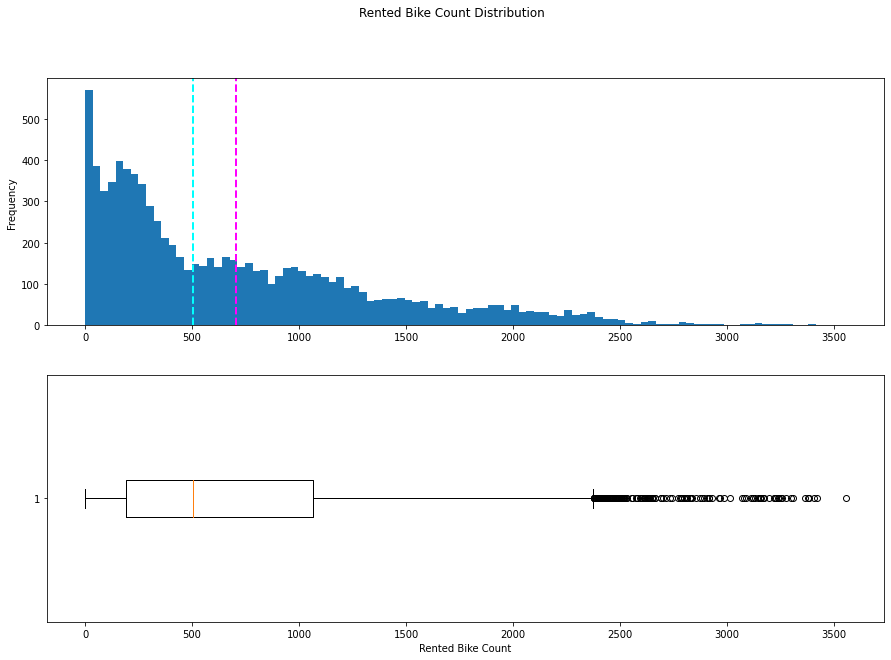

In [23]:
fig,ax = plt.subplots(2,1,figsize=(15,10))
# Plotting the histogram
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequency')

# Adding vertical Lines for Mean and Median
ax[0].axvline(label.mean(),color='magenta',linestyle='dashed',linewidth=2)
ax[0].axvline(label.median(),color='cyan',linestyle='dashed',linewidth=2)

# Plotting the boxplot
ax[1].boxplot(label,vert=False)
ax[1].set_xlabel('Rented Bike Count')

# Add a title to the figure
fig.suptitle('Rented Bike Count Distribution')

# Show the figure
fig.show()



The plots show that the number of daily rentals ranges from 0 to just over 3,400. However, the mean (and median) number of daily rentals is closer to the low end of that range, with most of the data between 0 and around 2,200 rentals. The few values above this are shown in the box plot as small circles, indicating that they are outliers 

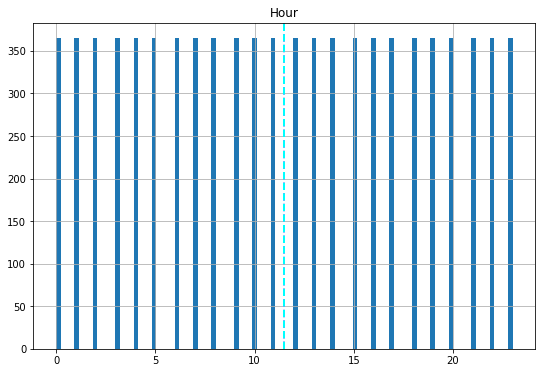

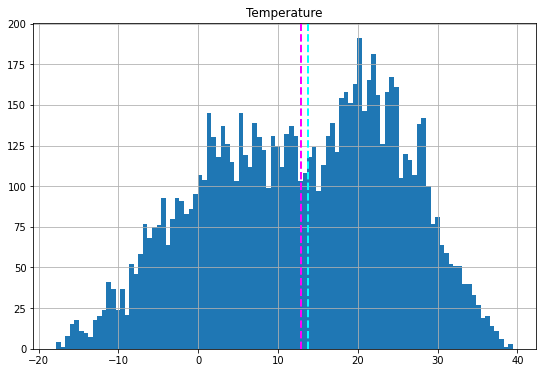

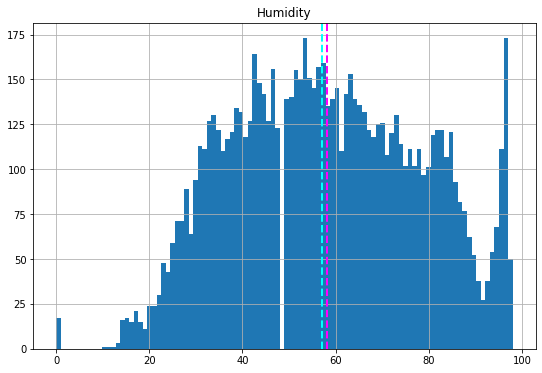

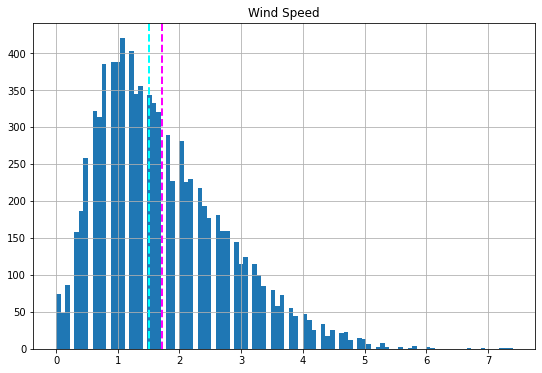

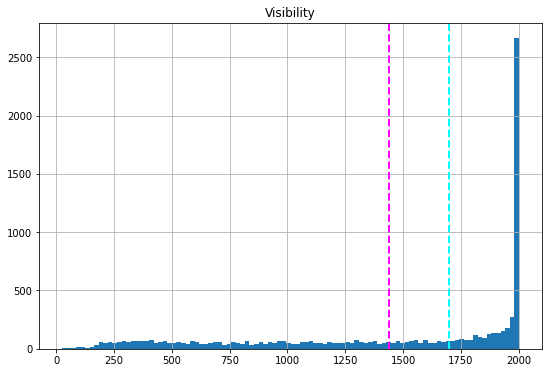

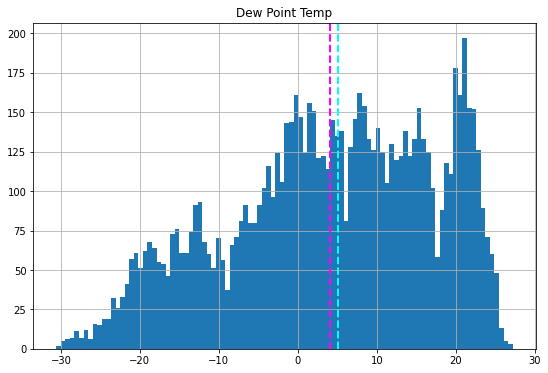

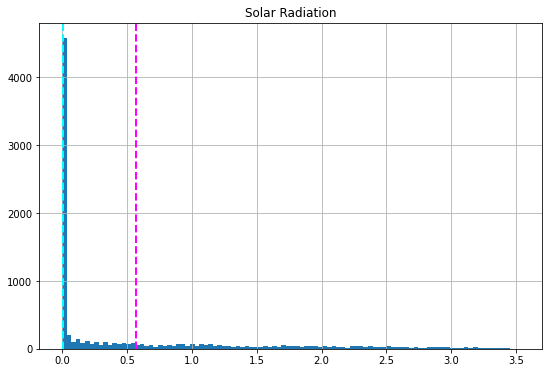

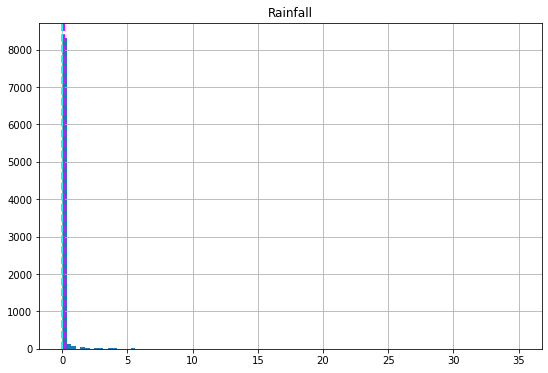

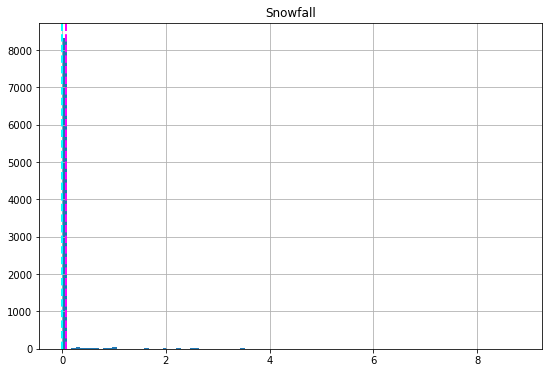

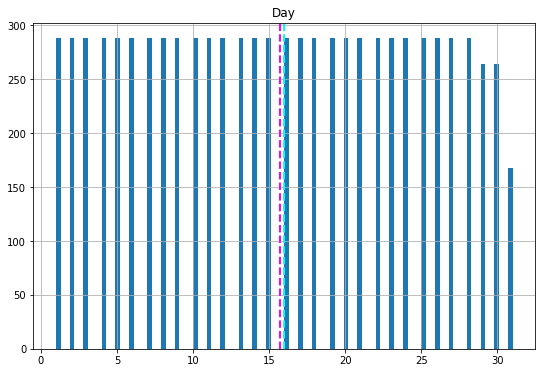

In [24]:
# Plot the histogram for each numeric feature
for col in numeric_features:
  fig = plt.figure(figsize=(9,6))
  ax = fig.gca()
  feature = bike_df[col]
  feature.hist(bins=100,ax=ax)
  ax.axvline(feature.mean(), color='magenta',linestyle='dashed', linewidth=2)
  ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
  ax.set_title(col)
plt.show()